In [1]:
from datasets import DynamicsDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

## Generate Dataset

In [2]:
dataset = DynamicsDataset(
    size=100,                # number of trajectories
    T=2,                     # total time
    sample_rate=0.01,        # time step
    params={'rho': 24.4},      # pass custom Lorenz63 parameters here
    dyn_sys_name='Lorenz63', # system name
    input_inds=[0],          # which variable(s) to use as input
    output_inds=[1,2],       # which variable(s) to use as output
    test=False
)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [3]:
for x, y, times_x, times_y in dataloader:
    print("Input batch shape:", x.shape)
    print("Output batch shape:", y.shape)
    print("Times shape:", times_x.shape)
    break  # Remove break to iterate through all batches

Input batch shape: torch.Size([16, 200, 1])
Output batch shape: torch.Size([16, 200, 2])
Times shape: torch.Size([16, 200, 1])


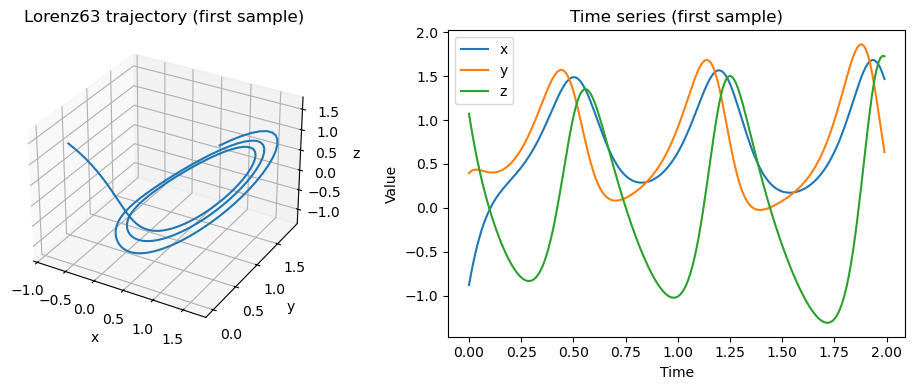

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Get the full normalized data from the dataset
# x: (n_traj, seq_len, input_dim), y: (n_traj, seq_len, output_dim)
x = dataset.x      # shape: (n_traj, seq_len, input_dim)
y = dataset.y      # shape: (n_traj, seq_len, output_dim)
t = dataset.times_x.squeeze(-1)  # shape: (seq_len,)

# For Lorenz63, if input_inds=[0] and output_inds=[1,2], you can reconstruct (x, y, z)
# x[:, :, 0] is x, y[:, :, 0] is y, y[:, :, 1] is z

# Take the first trajectory
x1 = x[0, :, 0].cpu().numpy()      # x
y1 = y[0, :, 0].cpu().numpy()      # y
z1 = y[0, :, 1].cpu().numpy()      # z

# Plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')
ax.plot(x1, y1, z1)
ax.set_title('Lorenz63 trajectory (first sample)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax2 = fig.add_subplot(122)
ax2.plot(t, x1, label='x')
ax2.plot(t, y1, label='y')
ax2.plot(t, z1, label='z')
ax2.set_title('Time series (first sample)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.legend()

plt.tight_layout()
plt.show()

## Set up Transformer

In [5]:
# Import deep learning modules
import torch
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
import wandb
from pytorch_lightning.tuner import Tuner

# Import custom modules
from datasets import MetaDataModule
from models.TNO.TNO_lightning import SimpleEncoderModule

In [6]:
# model hyperparmeters
d_model=32             # or 128, etc.
nhead=4                # or 8, etc.
num_layers=4           # or 6, etc.
activation='gelu'      # or 'gelu'
dim_feedforward=128    # or 2048, etc.
dropout = 0.1
lr = 1e-3

In [7]:
model = SimpleEncoderModule(
    input_dim=1,           # matches input_inds=[0]
    output_dim=2,          # matches output_inds=[1,2]
    domain_dim=1,
    d_model=d_model,            
    nhead=nhead,               
    num_layers=num_layers,          
    activation=activation,     
    dim_feedforward=dim_feedforward,   
    dropout=dropout,
    learning_rate=lr,
)

In [8]:
# Set up callbacks (optional but recommended)
lr_monitor = LearningRateMonitor(logging_interval='epoch')
early_stop = EarlyStopping(monitor='loss/val/mse', patience=10, mode="min")

# Set up PyTorch Lightning Trainer (no WandbLogger)
trainer = Trainer(
    max_epochs=100,
    callbacks=[lr_monitor, early_stop],
    accelerator="auto",  # use GPU if available
)

# Fit the model using the dataloader
trainer.fit(model, train_dataloaders=dataloader, val_dataloaders=dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/transformers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/opt/anaconda3/envs/transformers/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access th

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/transformers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/anaconda3/envs/transformers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/opt/anaconda3/envs/transformers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/transformers/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s, v_num=8, loss/val/mse=0.0172, loss/val/sup=1.190, loss/val/rel_L2=0.116, loss/train/mse=0.0321, loss/train/sup=1.320, loss/train/rel_L2=0.168]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 7/7 [00:01<00:00,  5.57it/s, v_num=8, loss/val/mse=0.0172, loss/val/sup=1.190, loss/val/rel_L2=0.116, loss/train/mse=0.0321, loss/train/sup=1.320, loss/train/rel_L2=0.168]


In [9]:
from utils import plot_lorenz_prediction_vs_truth

Sample 0: DTW y: 5.4941e-01, Pearson r y: 0.9968
Sample 0: DTW z: 8.8183e-01, Pearson r z: 0.9976


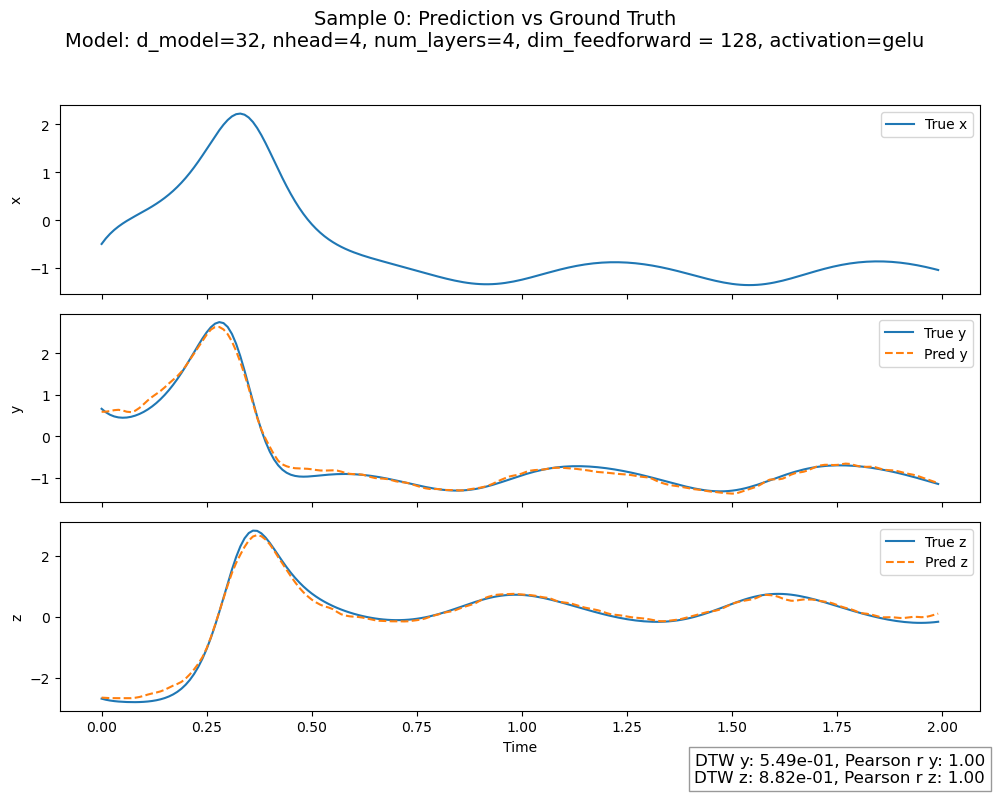

Sample 1: DTW y: 6.0493e-01, Pearson r y: 0.9956
Sample 1: DTW z: 5.3116e-01, Pearson r z: 0.9979


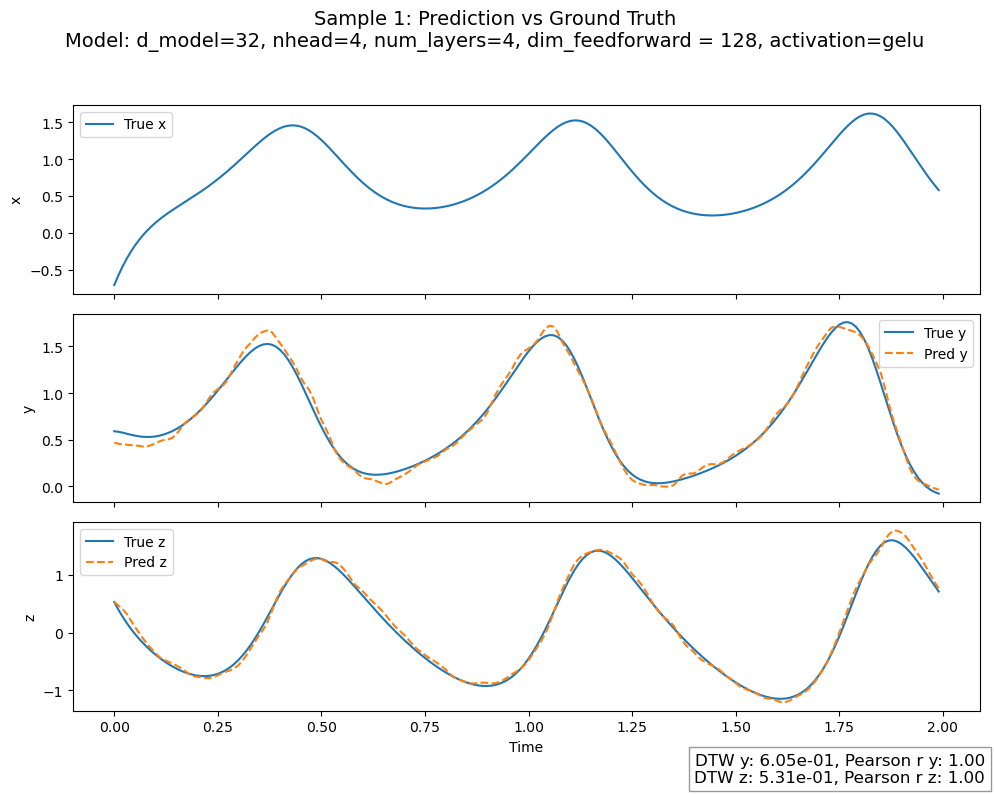

Sample 2: DTW y: 7.2580e-01, Pearson r y: 0.9550
Sample 2: DTW z: 7.4235e-01, Pearson r z: 0.9772


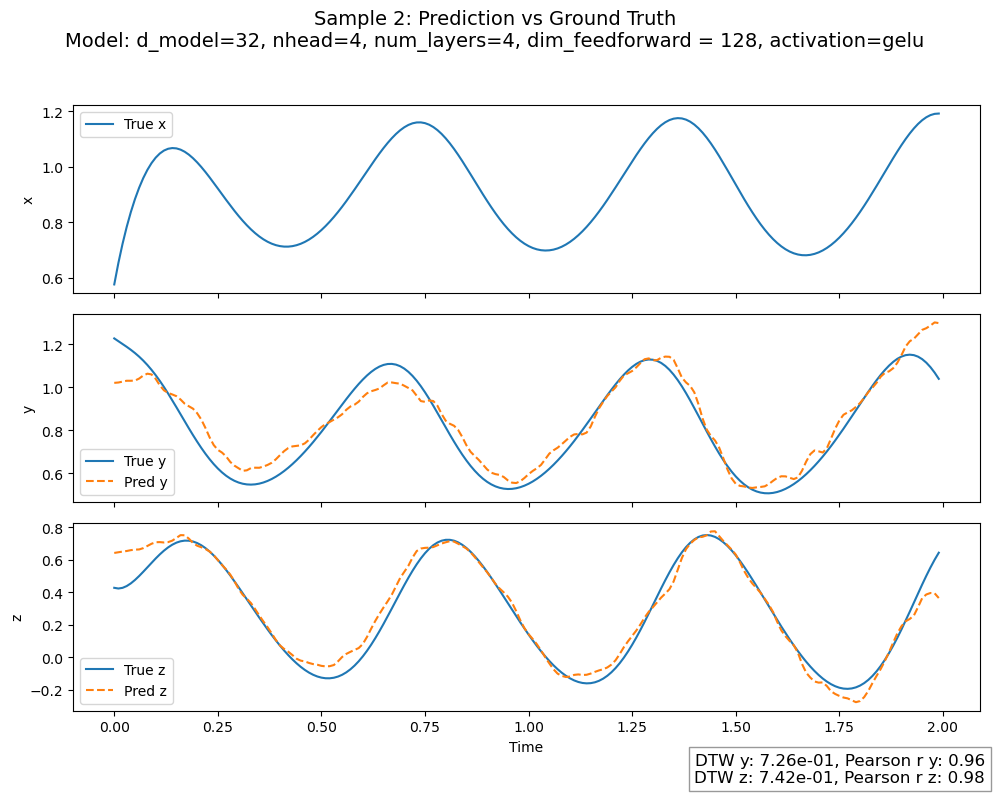

Sample 3: DTW y: 6.8546e-01, Pearson r y: 0.9940
Sample 3: DTW z: 6.5207e-01, Pearson r z: 0.9928


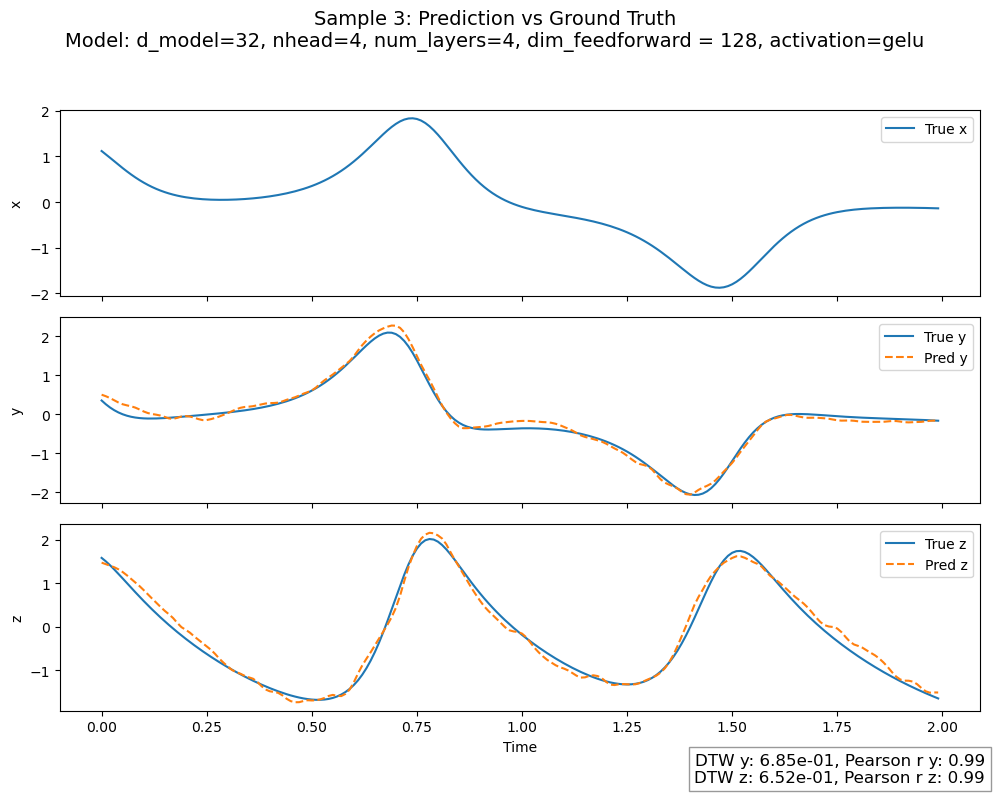

Sample 4: DTW y: 1.2272e+00, Pearson r y: 0.9862
Sample 4: DTW z: 1.0832e+00, Pearson r z: 0.9819


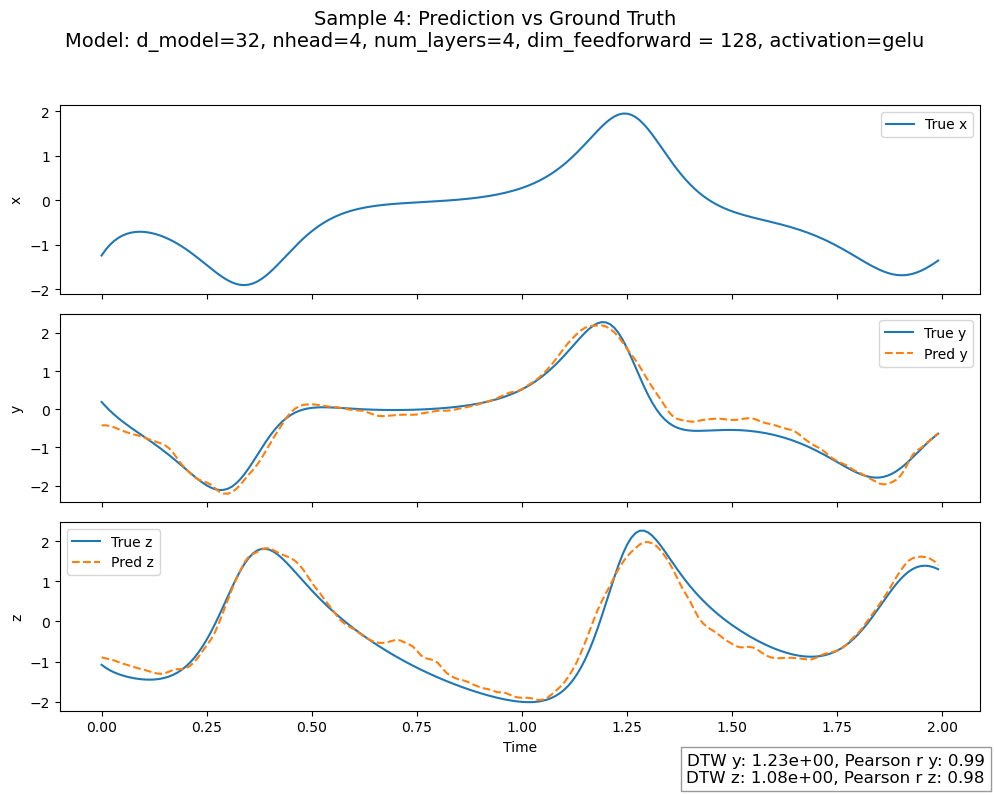

Sample 5: DTW y: 7.6588e-01, Pearson r y: 0.9745
Sample 5: DTW z: 1.2930e+00, Pearson r z: 0.9802


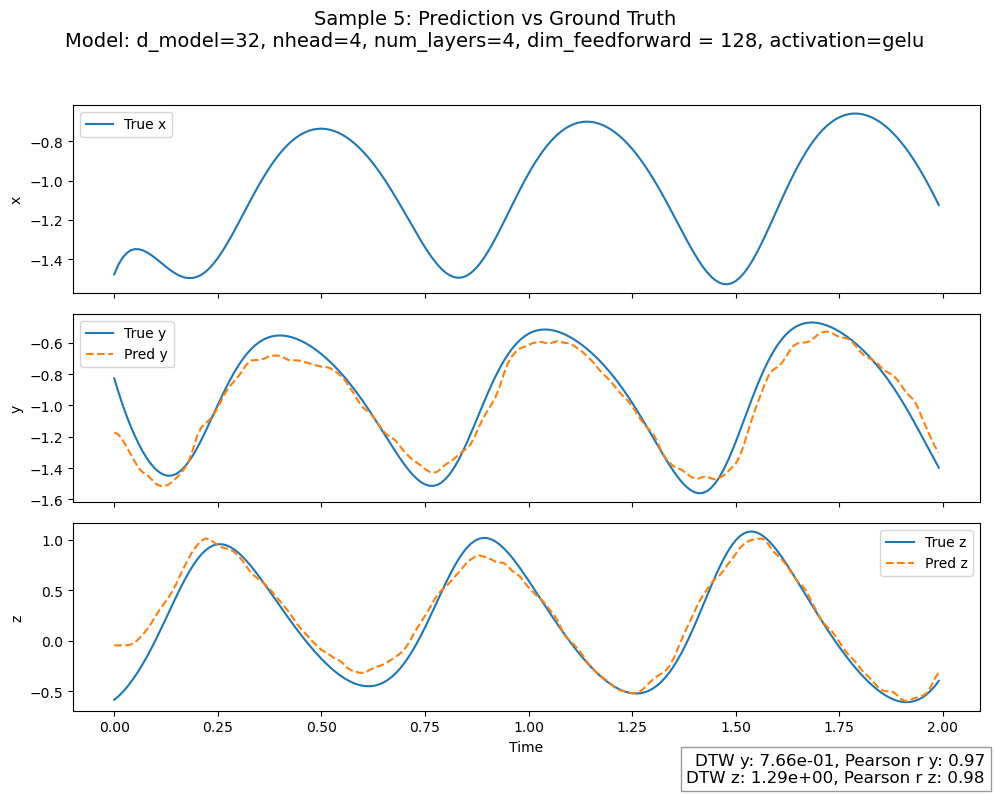

Sample 6: DTW y: 7.2637e-01, Pearson r y: 0.7257
Sample 6: DTW z: 9.8000e-01, Pearson r z: 0.7577


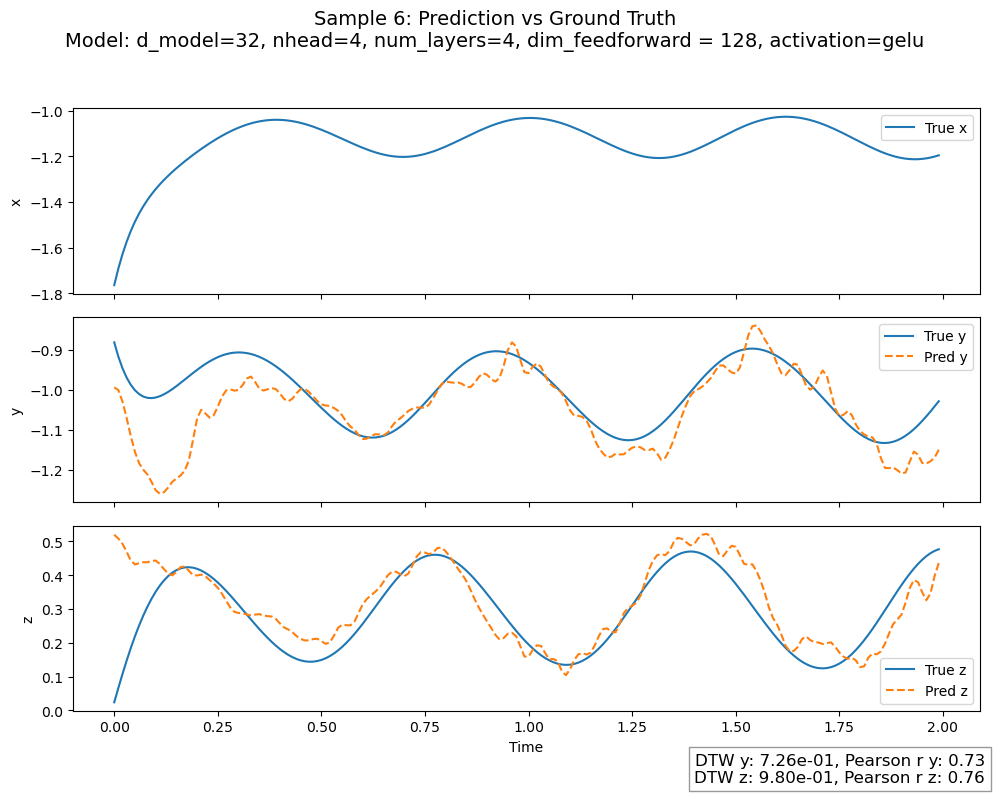

Sample 7: DTW y: 8.1607e-01, Pearson r y: 0.9976
Sample 7: DTW z: 8.0045e-01, Pearson r z: 0.9973


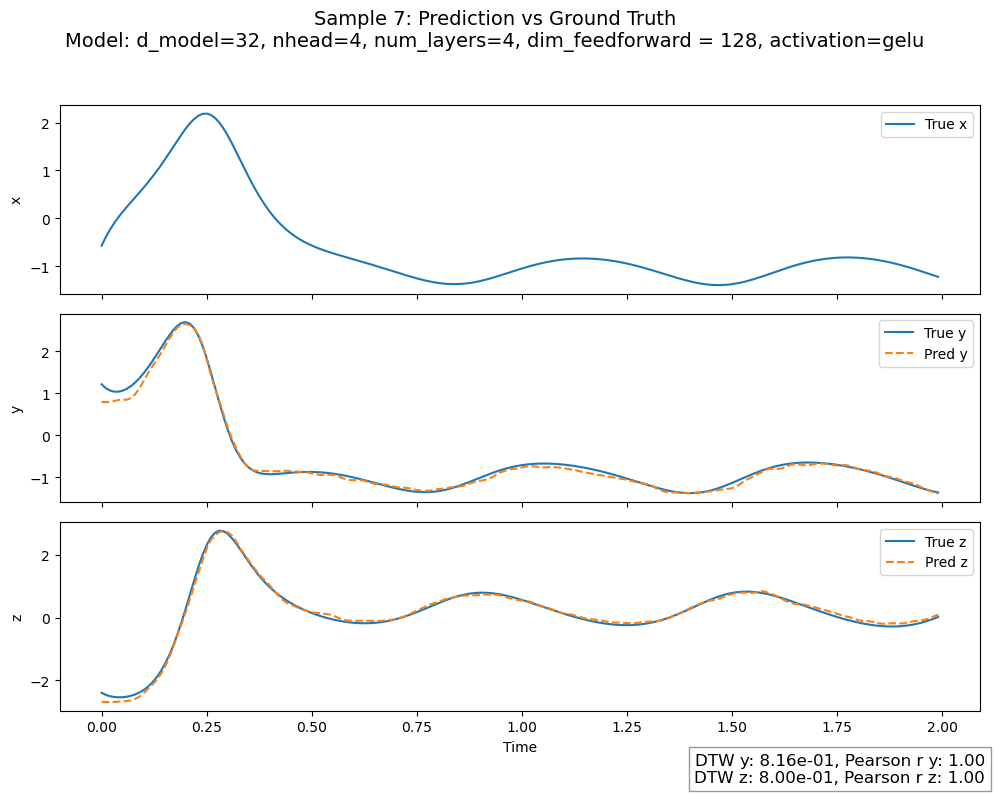

Sample 8: DTW y: 2.0345e+00, Pearson r y: 0.9725
Sample 8: DTW z: 7.2403e+00, Pearson r z: 0.9733


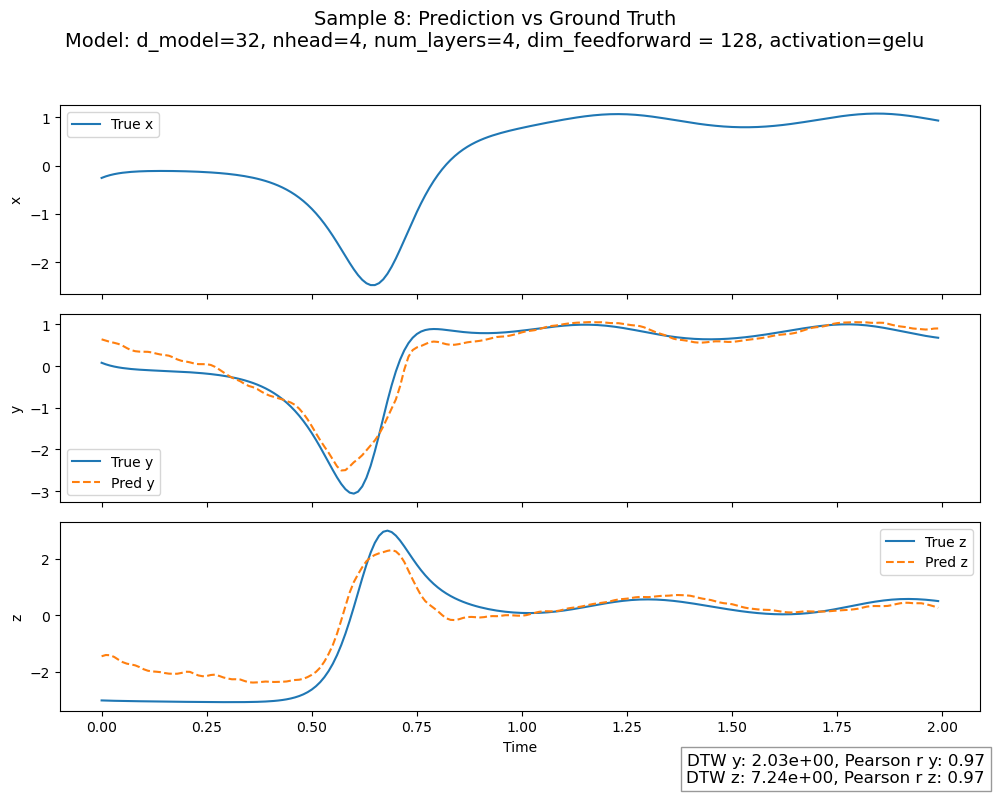

Sample 9: DTW y: 8.1747e-01, Pearson r y: 0.9960
Sample 9: DTW z: 6.1034e-01, Pearson r z: 0.9952


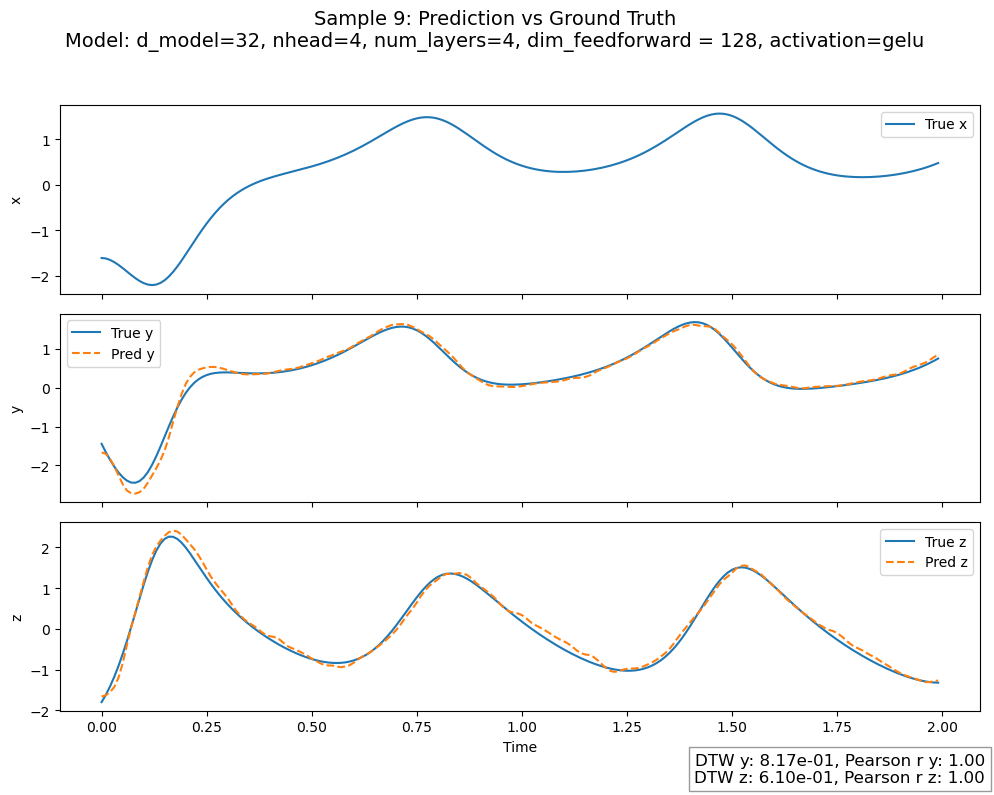

Sample 10: DTW y: 1.1067e+00, Pearson r y: 0.9921
Sample 10: DTW z: 7.2077e-01, Pearson r z: 0.9961


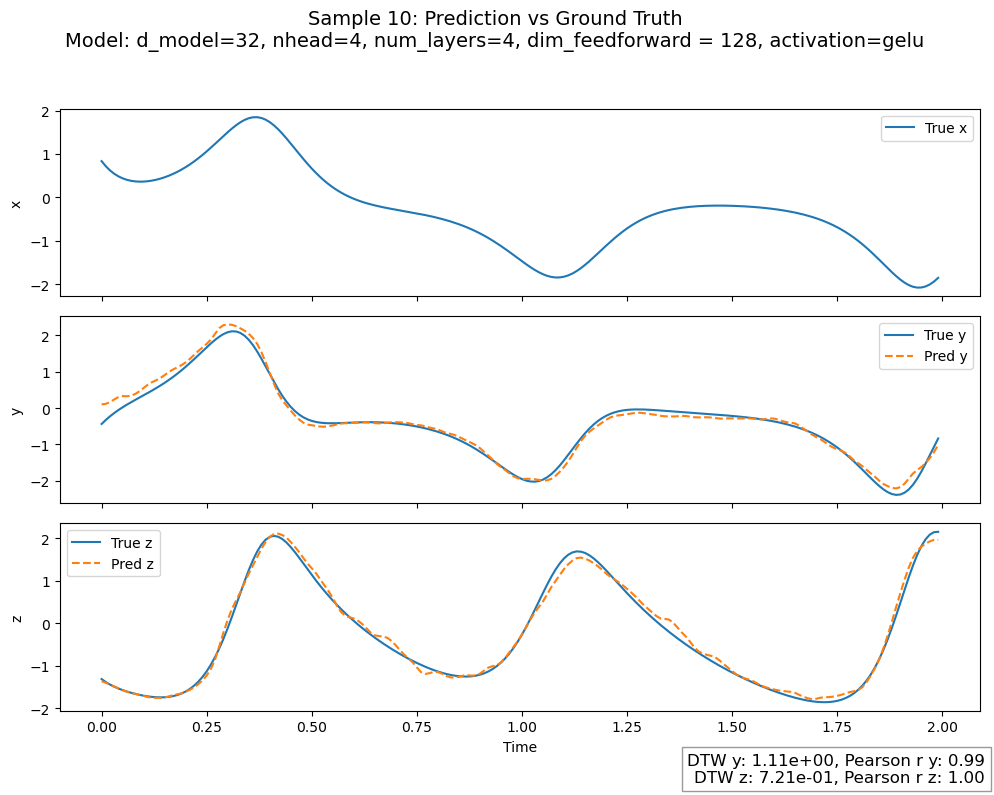

Sample 11: DTW y: 1.4219e+00, Pearson r y: 0.9924
Sample 11: DTW z: 8.7079e-01, Pearson r z: 0.9991


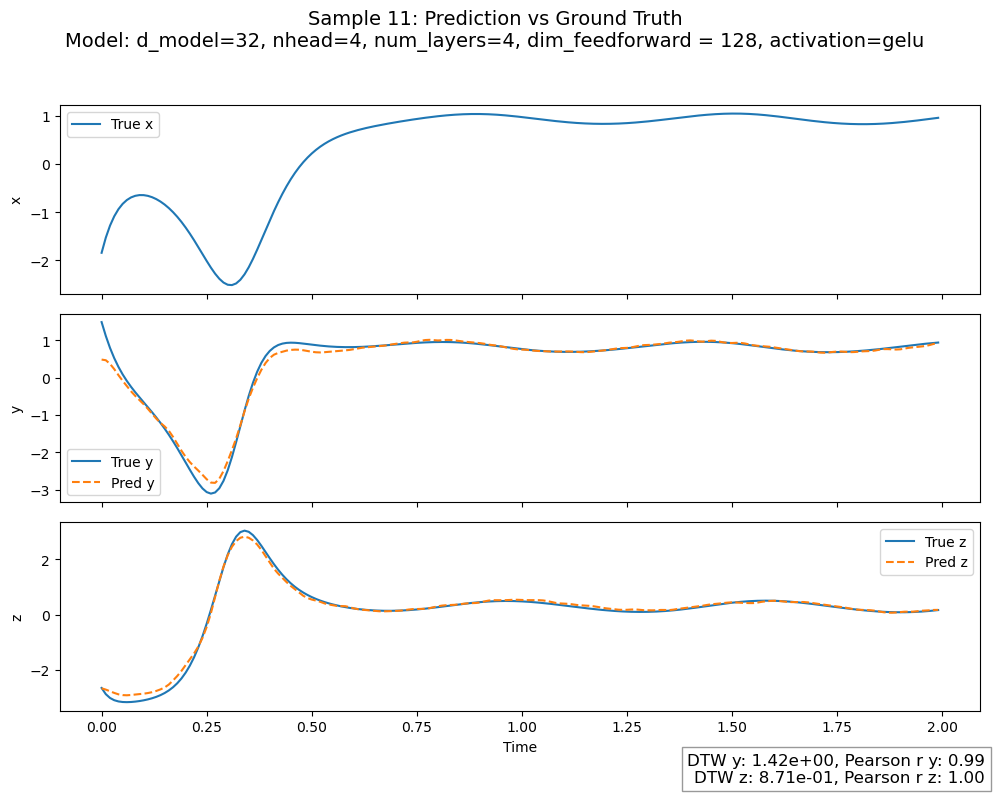

Sample 12: DTW y: 1.1476e+00, Pearson r y: 0.9872
Sample 12: DTW z: 1.3818e+00, Pearson r z: 0.9899


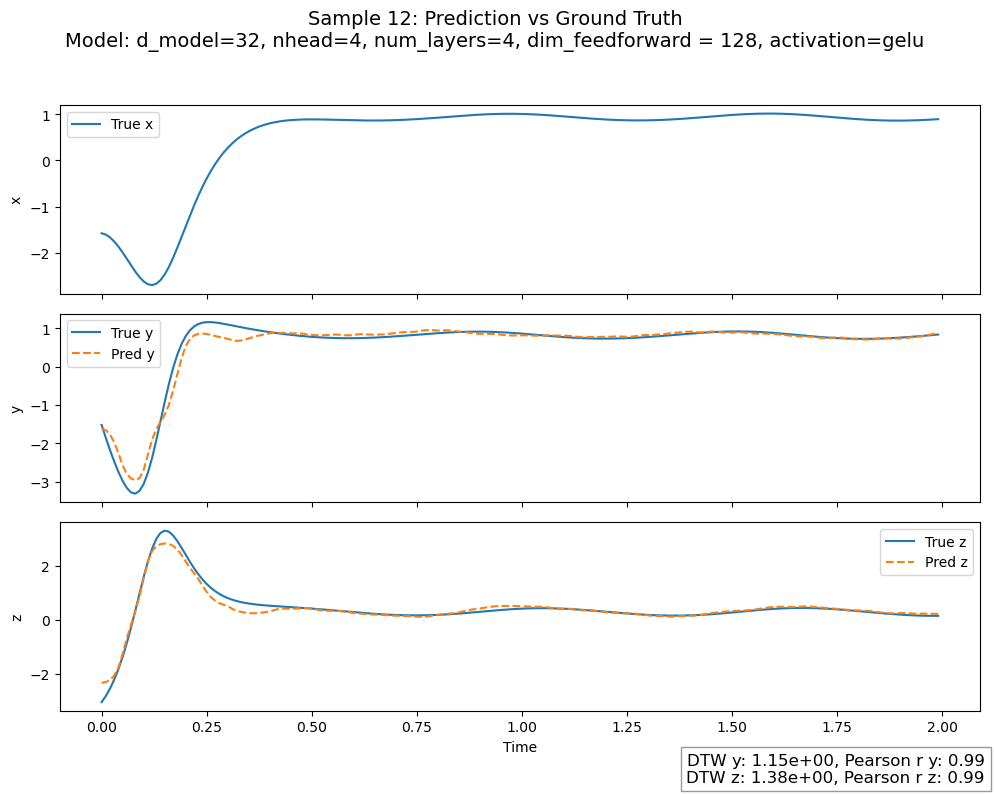

Sample 13: DTW y: 1.4880e+00, Pearson r y: 0.9792
Sample 13: DTW z: 1.0092e+00, Pearson r z: 0.9919


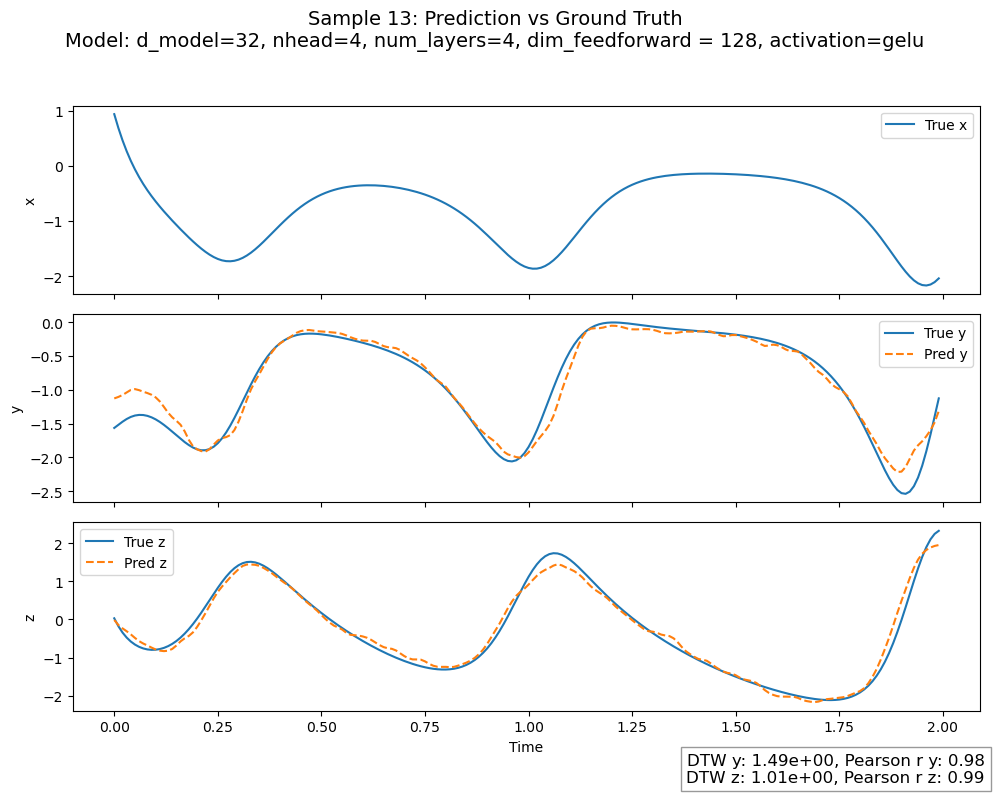

Sample 14: DTW y: 7.6835e-01, Pearson r y: 0.9749
Sample 14: DTW z: 2.9809e-01, Pearson r z: 0.9970


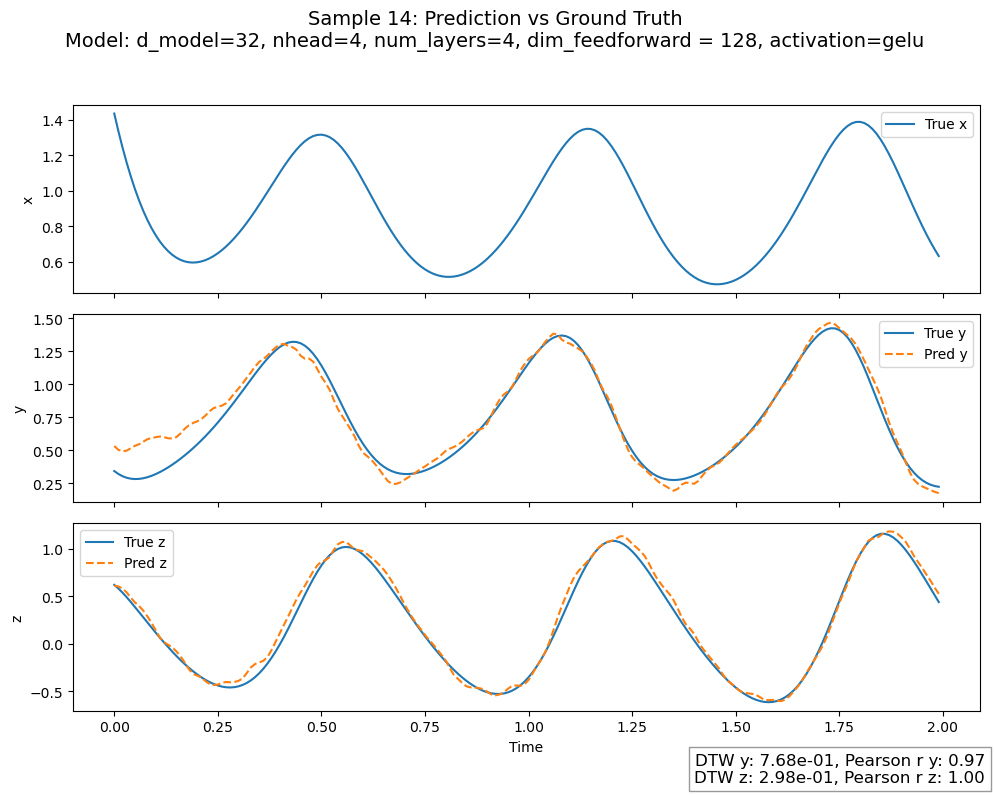

Sample 15: DTW y: 4.5470e-01, Pearson r y: 0.9865
Sample 15: DTW z: 8.2424e-01, Pearson r z: 0.9903


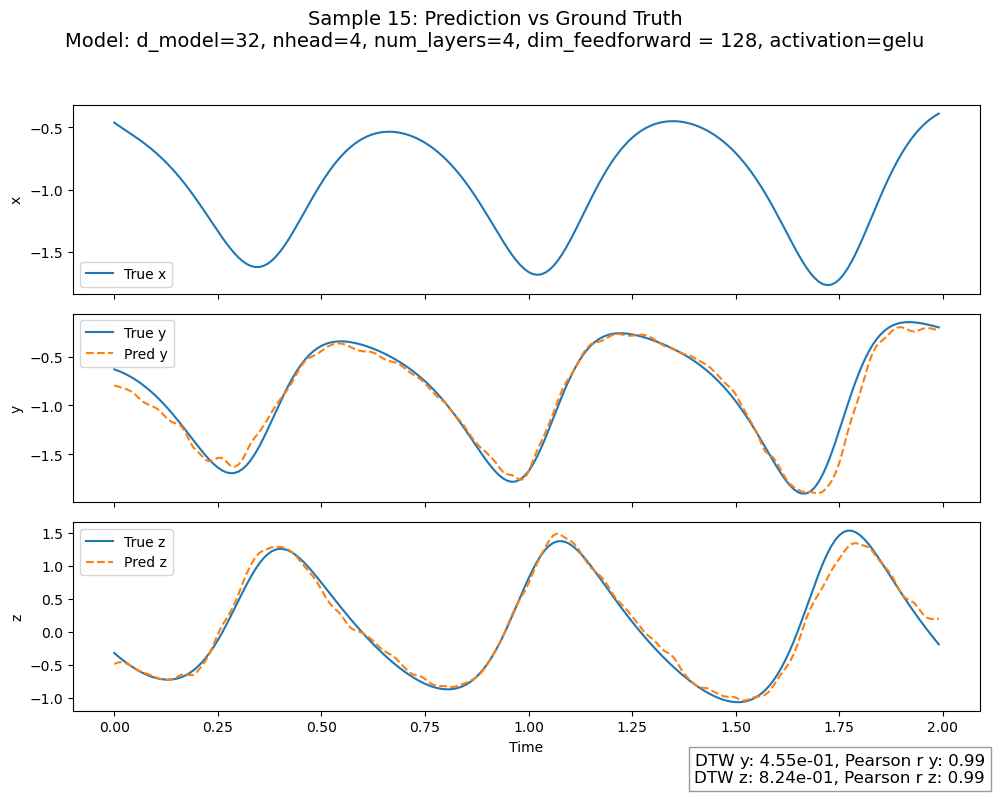

In [10]:
# Plot predictions vs ground truth for a batch from the dataloader
model.eval()
device = next(model.parameters()).device
with torch.no_grad():
    for x_batch, y_batch, times_x, times_y in dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        times_x = times_x.to(device)
        times_y = times_y.to(device)
        y_pred = model(x_batch, y_batch, times_x, times_y)
        break  # Only plot the first batch

# Assuming you want to use plot_lorenz_prediction_vs_truth for all samples in the current batch
for i in range(x_batch.shape[0]):
    t_i = times_y[i].cpu().numpy()
    x_true_i = x_batch[i, :, 0].cpu().numpy()
    y_true_i = y_batch[i, :, 0].cpu().numpy()
    z_true_i = y_batch[i, :, 1].cpu().numpy()
    y_pred_i = y_pred[i, :, 0].cpu().numpy()
    z_pred_i = y_pred[i, :, 1].cpu().numpy()
    plot_lorenz_prediction_vs_truth(
        t_i, x_true_i, y_true_i, z_true_i, y_pred_i, z_pred_i,
        title_prefix=f"Sample {i}: ",
        model_hparams=f"d_model={d_model}, nhead={nhead}, num_layers={num_layers}, dim_feedforward = {dim_feedforward}, activation=gelu"
    )